In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../source_code")

from loaders.output_loader import get_sorted_adj_mat_and_var_list
from loaders.import_gss import import_dataset
from loaders.clean_raw_data import clean_datasets

from generators.corr_make_network import calculate_correlation_matrix

from analyzers.belief_change import align_dfs
from analyzers.belief_change import subtract_dataframes
from analyzers.frustration_analyzer import calculate_frustration

In [25]:
start_years = [2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014]
interval = 4

corr_mats = {}
frust_mats = {}
corr_change_dfs = {}

df, _ = import_dataset()
cleaned_df = clean_datasets()

for i, start_year in enumerate(start_years):

    years_of_interest = list(range(start_year, start_year + interval))
    partial_corr_matrix = calculate_correlation_matrix(
        cleaned_df, 
        years_of_interest=years_of_interest,
        method="spearman", 
        partial=True, 
        edge_suppression="regularization",
        suppression_params={'regularization': 0.2})

    frust_mat = calculate_frustration(partial_corr_matrix, optimizer="multi_pass")

    corr_mats[start_year] = partial_corr_matrix
    frust_mats[start_year] = frust_mat

    if i > 0:
        corr_change_df = subtract_dataframes(
            corr_mats[start_year], 
            corr_mats[start_years[i-1]], mismatch_method="intersection")
        
        corr_change_dfs[start_years[i - 1]] = corr_change_df

Loading dataset from from cache...
Done! ✨
Loading dataset from from cache...
Done! ✨


In [55]:
# make a long list of correlation values 

corr_list = []
change_list = []
frust_list = []
for i, start_year in enumerate(start_years):
    if (i < len(start_years) - 1):
        corr_mat = corr_mats[start_year]
        corr_change = corr_change_dfs[start_year]
        frust_mat = frust_mats[start_year]

        corr_mat_aligned, corr_change_aligned = align_dfs(corr_mat, corr_change, method="intersection")
        frust_mat_aligned, corr_change_aligned = align_dfs(frust_mat, corr_change, method="intersection")

        print(corr_mat_aligned.shape)
        print(corr_change_aligned.shape)
        print(frust_mat_aligned.shape)

        flattened_corrs = corr_mat_aligned.values.flatten()
        flattened_changes = corr_change_aligned.values.flatten()
        flattened_frusts = frust_mat_aligned.values.flatten()

        corr_list += list(flattened_corrs[flattened_corrs != 0])
        change_list += list(flattened_changes[flattened_corrs != 0])
        frust_list += list(flattened_frusts[flattened_corrs != 0])
        
        print(len(frust_list), len(change_list), len(corr_list))

(115, 115)
(115, 115)
(115, 115)
636 636 636
(115, 115)
(115, 115)
(115, 115)
1302 1302 1302
(115, 115)
(115, 115)
(115, 115)
1994 1994 1994
(107, 107)
(107, 107)
(107, 107)
2668 2668 2668
(109, 109)
(109, 109)
(109, 109)
3330 3330 3330
(121, 121)
(121, 121)
(121, 121)
4170 4170 4170
(121, 121)
(121, 121)
(121, 121)
4992 4992 4992


[np.float64(9.571418032175744e-07), np.float64(0.000891367146002932), np.float64(0.0018038959386084536), np.float64(0.0027605240424702997), np.float64(0.003775385995880266), np.float64(0.004923587276587337), np.float64(0.00604728583180846), np.float64(0.00730500357297882), np.float64(0.00863193892802082), np.float64(0.009804951138780788), np.float64(0.01112244323288108), np.float64(0.01216218221852806), np.float64(0.013612085465833007), np.float64(0.015018111423992514), np.float64(0.01646947889276154), np.float64(0.017594502501980264), np.float64(0.019091667154235374), np.float64(0.020838301915317756), np.float64(0.022746043258838243), np.float64(0.02476957781549513), np.float64(0.026549233198728716), np.float64(0.028297402512762398), np.float64(0.029746352940327063), np.float64(0.03196434690482621), np.float64(0.034765839703126446), np.float64(0.037998503023019096), np.float64(0.040405068775182934), np.float64(0.04365330445469307), np.float64(0.04659254165192539), np.float64(0.0494916

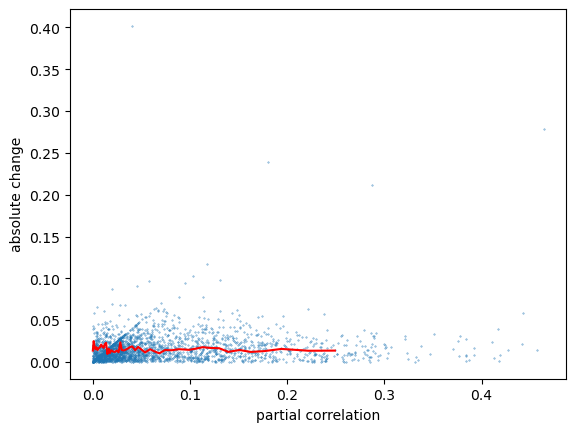

In [60]:
plt.scatter(np.abs(corr_list), np.abs(change_list), alpha=0.5, s=0.1)

# Sort the absolute correlations
things_to_bin = np.sort(np.abs(corr_list))

# Determine the bin edges such that each bin has 50 entries
bin_edges = [things_to_bin[i] for i in range(0, len(things_to_bin), 100)]
print(bin_edges)

bin_edges[-1] = things_to_bin[-1] # Ensure the last edge includes the maximum value

# Calculate the average frustration for each bin
bin_means = []

print(bin_edges)
for i in range(len(bin_edges) - 1):
    bin_mask = (things_to_bin >= bin_edges[i]) & (things_to_bin < bin_edges[i + 1])
    # calculate the relevant change entries
    relevant_changes = np.abs(change_list)[bin_mask]
    
    # sum the number of nan values in here
    bin_means.append(np.abs(change_list)[bin_mask].mean())

# Plot the average frustration for each bin
plt.plot(bin_edges[:-1], bin_means, color="r")
plt.xlabel('partial correlation')
plt.ylabel('absolute change')
plt.show()

[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.001), np.float64(0.005), np.float64(0.009), np.float64(0.013), np.float64(0.017), np.float64(0.022), np.float64(0.039), np.float64(0.053), np.float64(0.074), np.float64(0.102), np.float64(0.127), np.float64(0.145), np.float64(0.155), np.float64(0.173), np.float64(0.196), np.float64(0.221), np.float64(0.242), np.float64(0.267), np.float64(0.29), np.float64(0.307), np.float64(0.323), np.float64(0.336), np.float64(0.35), np.float64(0.359), np.float64(0.369), np.float64(0.378), np.float64(0.386), np.float64(0.4), np.float64(0.411), np.float64(0.42), np.float64(0.431), np.float64(0.44), np.float64(0.449), np.float64(0.458), np.float64(0.467), np.float64(0.48), np.float64(0.493), np.float64(0.51)]
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0

C:\Users\vicvi\AppData\Local\Temp\ipykernel_17604\611019303.py:22: RuntimeWarning: Mean of empty slice.
  bin_means.append(np.abs(change_list)[bin_mask].mean())


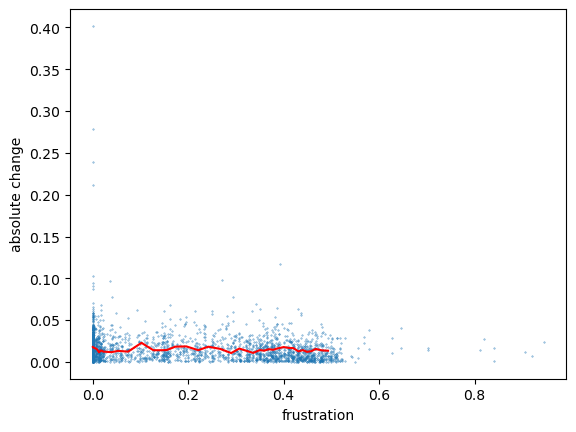

In [ ]:
plt.scatter(frust_list, np.abs(change_list), alpha=0.5, s=0.1)

# Sort the absolute correlations
things_to_bin = np.sort(frust_list)

# Determine the bin edges such that each bin has 50 entries
bin_edges = [things_to_bin[i] for i in range(0, len(things_to_bin), 100)]
print(bin_edges)

bin_edges[-1] = things_to_bin[-1] # Ensure the last edge includes the maximum value

# Calculate the average frustration for each bin
bin_means = []

print(bin_edges)
for i in range(len(bin_edges) - 1):
    bin_mask = (things_to_bin >= bin_edges[i]) & (things_to_bin < bin_edges[i + 1])
    # calculate the relevant change entries
    relevant_changes = np.abs(change_list)[bin_mask]
    
    # sum the number of nan values in here
    bin_means.append(np.abs(change_list)[bin_mask].mean())

# Plot the average frustration for each bin
plt.plot(bin_edges[:-1], bin_means, color="r")
plt.xlabel('frustration')
plt.ylabel('absolute change')
plt.show()

In [46]:
#find the number of nan values 
nan_count = np.sum(np.isnan(change_list))
nan_count

np.int64(0)

In [9]:
print(stack_of_corrs.shape)
print(stack_of_changes.shape)

NameError: name 'stack_of_corrs' is not defined

In [ ]:
""" TODO put this into a test file"""

# Example usage
data1 = {
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9]
}
data2 = {
    'B': [2, 4, 6],
    'C': [8, 10, 12],
    'D': [14, 16, 18]
}

df1 = pd.DataFrame(data1, index=['A', 'B', 'C'])
df2 = pd.DataFrame(data2, index=['B', 'C', 'D'])

result = subtract_dataframes(df1, df2)
print(result)
